In [1]:
import pandas as pd
import numpy as np

import pickle

import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

from importlib import reload  # Python 3.4+

from sklearn import metrics
import seaborn as sns
sns.set()

from sklearn.calibration import CalibratedClassifierCV

from IPython.display import clear_output, display

In [2]:
train_df = pd.read_csv('train_for_2012.csv',index_col=0)
train_df.shape

(837913, 43)

In [3]:
test_df = pd.read_csv('test_for_2012.csv',index_col=0)
test_df.shape

(185639, 43)

In [4]:
# df['is_first_occurrence'] = (df['id'] != df['id'].shift()).astype(int)

In [5]:
# modeling_df = df[df['is_first_occurrence']==1].copy()
# print(modeling_df.shape)
# len(modeling_df)/len(df)

In [6]:
train_df['stmt_date'] = pd.to_datetime(train_df['stmt_date'])
train_df['def_date'] = pd.to_datetime(train_df['def_date'], format="%d/%m/%Y")
train_df.sort_values('stmt_date', inplace=True)

In [7]:
### we'll try dropping NA's for now
train_df.sort_values('stmt_date', inplace=True)

In [8]:
test_df['stmt_date'] = pd.to_datetime(test_df['stmt_date'])
test_df['def_date'] = pd.to_datetime(test_df['def_date'], format="%d/%m/%Y")
test_df.sort_values('stmt_date', inplace=True)

## Get preprocessing data ready

In [9]:
from preproc_functions import pre_process

In [10]:
with open('quantile_custom_bins.pkl', 'rb') as file:
    custom_bins = pickle.load(file)

In [11]:
preproc_params = {
    'quantile_bins' : {},
    'quantile_values' : {}
}

In [12]:
train_data_proc , preproc_params = pre_process(train_df, 
                                               custom_bins=custom_bins, 
                                               preproc_params = preproc_params,  
                                               quantiles = 50, 
                                               days_until_statement = 150)

Custom bins for financial_leverage_quantile
Custom bins for profitability_ratio_quantile


/Users/juanroalvarado/miniconda3/envs/horserace/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/juanroalvarado/nyu/finance/ml-finance-credit-default/final_harness/preproc_functions.py:149: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[growth_feature].fillna(0, inplace=True)


Custom bins for net_income_growth_quantile


/Users/juanroalvarado/nyu/finance/ml-finance-credit-default/final_harness/preproc_functions.py:149: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[growth_feature].fillna(0, inplace=True)
/Users/juanroalvarado/miniconda3/envs/horserace/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/juanroalvarado/miniconda3/envs/horserace/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4622: RuntimeWarning: invalid value

In [13]:
test_data_proc , preproc_params = pre_process(test_df, 
                                             historical_df=train_data_proc, 
                                             new=False, 
                                             preproc_params = preproc_params,  
                                             quantiles = 50, 
                                             days_until_statement = 150)

asst_tot_quantile
financial_leverage_quantile
profitability_ratio_quantile
roe_quantile


/Users/juanroalvarado/nyu/finance/ml-finance-credit-default/final_harness/preproc_functions.py:171: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[growth_feature_name].fillna(0, inplace=True)


net_income_growth_quantile
quick_ratio_v2_quantile


/Users/juanroalvarado/nyu/finance/ml-finance-credit-default/final_harness/preproc_functions.py:171: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[growth_feature_name].fillna(0, inplace=True)


sales_growth_quantile
cash_assets_ratio_quantile
dscr_quantile
cfo_quantile


In [15]:
test_data_proc.columns#.tail(10)

Index(['id', 'stmt_date', 'HQ_city', 'legal_struct', 'ateco_sector',
       'def_date', 'fs_year', 'asst_intang_fixed', 'asst_tang_fixed',
       'asst_fixed_fin', 'asst_current', 'AR', 'cash_and_equiv', 'asst_tot',
       'eqty_tot', 'eqty_corp_family_tot', 'liab_lt', 'liab_lt_emp',
       'debt_bank_st', 'debt_bank_lt', 'debt_fin_st', 'debt_fin_lt', 'AP_st',
       'AP_lt', 'debt_st', 'debt_lt', 'rev_operating', 'COGS',
       'prof_operations', 'goodwill', 'inc_financing', 'exp_financing',
       'prof_financing', 'inc_extraord', 'taxes', 'profit', 'days_rec',
       'ebitda', 'roa', 'roe', 'wc_net', 'margin_fin', 'cf_operations',
       'default', 'asst_tot_quantile', 'asst_tot_quantile_values', 'liab_tot',
       'financial_leverage', 'financial_leverage_quantile',
       'financial_leverage_quantile_values', 'profitability_ratio',
       'profitability_ratio_quantile', 'profitability_ratio_quantile_values',
       'roe_quantile', 'roe_quantile_values', 'net_income',
       'net_i

## Train algorithm

In [73]:
### features for first firm
first_features = [
    # 'asst_tot_quantile_values', ####
    'financial_leverage_quantile_values',
    'profitability_ratio_quantile_values',
    # 'net_income_growth_quantile_values',
    'quick_ratio_v2_quantile_values',
    # 'sales_growth_quantile_values',
    # 'cash_assets_ratio_quantile_values', ####
    'dscr_quantile_values',
    'roe_quantile_values',
    'cfo_quantile_values',
    # 'ebitda',
    # 'ateco_sector_pd',
    # 'sector_group_pd', ####
    # 'legal_struct_pd',
    'regional_code_pd' ####
]


In [74]:
### features for recurring firms
rec_features = [
    # 'asst_tot_quantile_values', ###
    'financial_leverage_quantile_values',
    'profitability_ratio_quantile_values',
    'net_income_growth_quantile_values',
    'quick_ratio_v2_quantile_values',
    'sales_growth_quantile_values',
    # 'cash_assets_ratio_quantile_values',###
    'dscr_quantile_values',
    'roe_quantile_values',
    'cfo_quantile_values',
    # 'ebitda', ###
    # 'ateco_sector_pd',###
    # 'sector_group_pd',###
    # 'legal_struct_pd',###
    'regional_code_pd'

]

In [75]:
train_data_proc[rec_features].isna().sum()

financial_leverage_quantile_values     0
profitability_ratio_quantile_values    0
net_income_growth_quantile_values      0
quick_ratio_v2_quantile_values         0
sales_growth_quantile_values           0
dscr_quantile_values                   0
roe_quantile_values                    0
cfo_quantile_values                    0
regional_code_pd                       0
dtype: int64

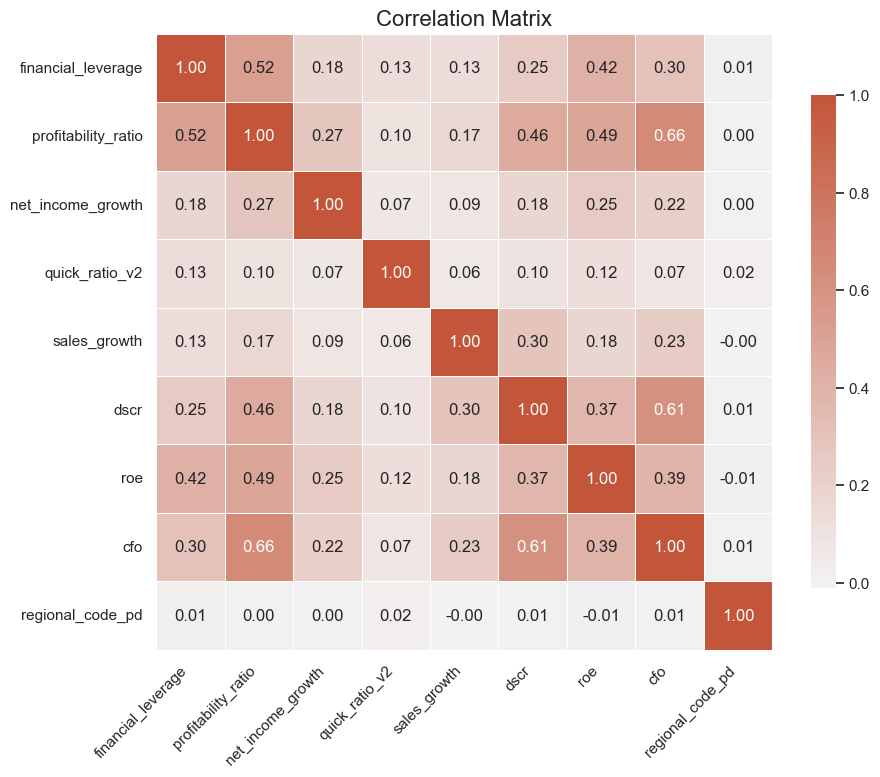

In [76]:
# Compute the correlation matrix
corr = train_data_proc[train_data_proc['is_first_occurrence']==0][rec_features].corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Create the heatmap with annotations
ax = sns.heatmap(corr, annot=True, fmt=".2f", cmap=cmap, center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})

# Set title and display the plot
plt.title("Correlation Matrix", fontsize=16)
ticks = [i.split('_quantile_values')[0] for i in corr.index]
ax.set_xticklabels(ticks, rotation=45, ha='right')
ax.set_yticklabels(ticks, rotation=0, va='center')

# plt.xticks(rotation0)
plt.show()


In [77]:
 from statsmodels.stats.outliers_influence import variance_inflation_factor

In [78]:

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = train_data_proc[rec_features].columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(train_data_proc[train_data_proc['is_first_occurrence']==0][rec_features].values, i)
                          for i in range(len(train_data_proc[train_data_proc['is_first_occurrence']==0][rec_features].columns))]

print(vif_data)

                               feature       VIF
0   financial_leverage_quantile_values  1.823451
1  profitability_ratio_quantile_values  2.956553
2    net_income_growth_quantile_values  2.392645
3       quick_ratio_v2_quantile_values  6.391628
4         sales_growth_quantile_values  3.712859
5                 dscr_quantile_values  3.036103
6                  roe_quantile_values  2.204549
7                  cfo_quantile_values  3.490608
8                     regional_code_pd  7.927132


In [79]:

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = train_data_proc[first_features].columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(train_data_proc[train_data_proc['is_first_occurrence']==1][first_features].values, i)
                          for i in range(len(train_data_proc[train_data_proc['is_first_occurrence']==1][first_features].columns))]

print(vif_data)

                               feature       VIF
0   financial_leverage_quantile_values  1.880187
1  profitability_ratio_quantile_values  2.729893
2       quick_ratio_v2_quantile_values  6.699677
3                 dscr_quantile_values  2.692984
4                  roe_quantile_values  1.922172
5                  cfo_quantile_values  3.369052
6                     regional_code_pd  6.897326


In [80]:
first_formula = 'default ~ '+' + '.join(first_features)
first_formula

'default ~ financial_leverage_quantile_values + profitability_ratio_quantile_values + quick_ratio_v2_quantile_values + dscr_quantile_values + roe_quantile_values + cfo_quantile_values + regional_code_pd'

In [81]:
rec_formula = 'default ~ '+' + '.join(rec_features)
rec_formula

'default ~ financial_leverage_quantile_values + profitability_ratio_quantile_values + net_income_growth_quantile_values + quick_ratio_v2_quantile_values + sales_growth_quantile_values + dscr_quantile_values + roe_quantile_values + cfo_quantile_values + regional_code_pd'

In [82]:
class SplitModel():
    def __init__(self, algo):
        self.first_formula = 'default ~ '+' + '.join(first_features)
        self.rec_formula = 'default ~ '+' + '.join(rec_features)

        self.algo = algo
    
    def train(self, data):
        
        rec_data = data[data['is_first_occurrence']==0]
        first_data = data[data['is_first_occurrence']==1]
        
        self.first_model = self.algo(self.first_formula, data = first_data)
        self.first_fitted_model = self.first_model.fit()

        self.rec_model = self.algo(self.rec_formula, data = rec_data)
        self.rec_fitted_model = self.rec_model.fit()
        print("models fit")

    def predict(self, data):
        rec_data = data[data['is_first_occurrence']==0]
        first_data = data[data['is_first_occurrence']==1]
        print('rec data length',len(rec_data))
        print('first data length',len(first_data))
        
        rec_preds = self.rec_fitted_model.predict(rec_data)
        rec_preds = rec_preds.reindex(rec_data.index)
        
        first_preds = self.first_fitted_model.predict(first_data)
        first_preds = first_preds.reindex(first_data.index)

        predictions = pd.concat([rec_preds,first_preds]).reindex(data.index)
        
        return predictions

    def summary(self):
        print('~~~~~ First Time First Model ~~~~~~')
        print(self.first_fitted_model.summary())
        print(self.first_fitted_model.get_margeff().summary())
        print('\n')
        print('~~~~~ Recurring First Model ~~~~~~')
        print(self.rec_fitted_model.summary())
        print(self.rec_fitted_model.get_margeff().summary())
        print('\n')
        

In [83]:
train_data_proc.shape

(837913, 83)

In [84]:
test_data_proc.shape

(185639, 83)

In [99]:
model = SplitModel(algo=smf.probit)

In [100]:
model.train(train_data_proc)

Optimization terminated successfully.
         Current function value: 0.050370
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.062840
         Iterations 9
models fit


In [101]:
preds = model.predict(train_data_proc)

rec data length 612920
first data length 224993


In [102]:
preds

Unnamed: 0
22         0.008117
18         0.048828
19         0.053491
23         0.007954
17         0.007661
             ...   
4437676    0.008795
4437705    0.004192
4437703    0.031861
4437709    0.003937
4437706    0.006013
Length: 837913, dtype: float64

### Model results

In [103]:
model.summary()

~~~~~ First Time First Model ~~~~~~
                          Probit Regression Results                           
Dep. Variable:                default   No. Observations:               224993
Model:                         Probit   Df Residuals:                   224985
Method:                           MLE   Df Model:                            7
Date:                Thu, 14 Nov 2024   Pseudo R-squ.:                  0.1119
Time:                        13:06:42   Log-Likelihood:                -11333.
converged:                       True   LL-Null:                       -12761.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              -3.1493      0.051    -62.249      0.000      -3.248      -3.050
financial_leverage_q

In [104]:
# train_data_proc.to_csv('train_processed_data_for_2012.csv')
# test_data_proc.to_csv('test_processed_data_for_2012.csv')

## Process test data

In [105]:
test_predictions = model.predict(test_data_proc)

rec data length 172921
first data length 12718


In [106]:
test_results = test_data_proc[['default']].copy()
test_results['predictions'] = test_predictions

In [107]:
test_results.head()

,default,predictions
Unnamed: 0,,
21,0,0.069132
2757816,0,0.074200
2757825,0,0.007069
2757832,0,0.001861
2757853,0,0.002758


In [108]:
metrics.roc_auc_score(y_score=test_results['predictions'], y_true=test_results['default'])

np.float64(0.8520403815037432)

ROC AUC 0.8520403815037432


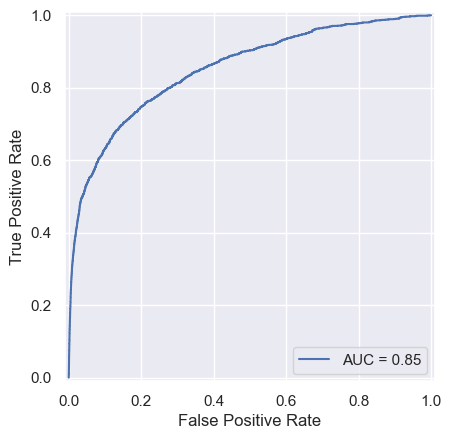

In [109]:
fpr, tpr, thresholds = metrics.roc_curve(test_results['default'], test_results['predictions'])
roc_auc = metrics.auc(fpr, tpr)
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
print(f'ROC AUC {roc_auc}')
roc_display.plot()

In [110]:
# train_data_proc.to_csv('train_processed_data_for_2012.csv', index=False)
# test_data_proc.to_csv('test_processed_data_for_2012.csv', index=False)

## saving components for harness

In [111]:
growth_features = [
    'id',
    'stmt_date',
    'net_income',
    'sales'
]

In [112]:
historical_growth = train_data_proc[growth_features]#.to_csv('historical_features.csv')
historical_growth.head()

,id,stmt_date,net_income,sales
Unnamed: 0,,,,
22,520288,2007-12-31,36733.0,2041155.0
18,520288,2008-12-31,-107382.0,967389.0
19,520288,2009-12-31,-77819.0,638687.0
23,520288,2010-12-31,-83593.0,564622.0
17,520288,2011-12-31,-81288.0,538081.0


In [42]:
historical_growth.to_csv('historical_features.csv')

In [43]:
with open('custom_bins.pkl', 'wb') as output:
    pickle.dump(custom_bins, output)

In [44]:
with open('preproc_params.pkl', 'wb') as output:
    pickle.dump(preproc_params, output)

In [45]:
with open('trained_model.pkl', 'wb') as output:
    pickle.dump(model, output)